In [1]:
import os
from collections.abc import Iterable
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from torch import nn
import logging
from mne.viz import plot_topomap

# from scipy.signal import welch
from meegnet.parsing import parser
from meegnet.params import TIME_TRIAL_LENGTH
from meegnet.utils import load_checkpoint, compute_psd, cuda_check
from meegnet.dataloaders import BANDS, load_data
from pytorch_grad_cam import GuidedBackpropReLUModel
from meegnet.viz import load_info, make_gif
from meegnet.util_viz import (
    save_gradient_images,
    convert_to_grayscale,
    get_positive_negative_saliency,
)
from meegnet.network import create_net

In [2]:
DEVICE = cuda_check()
LABELS = ["image", "sound"]  # image is label 0 and sound label 1
CHANNELS = ["MAG"]  # ("GRAD", "GRAD2", "MAG")

In [3]:
def compute_save_guided_bprop(net, X, y):
    GBP = GuidedBackpropReLUModel(net)
    guided_grads = GBP.generate_gradients(X, y)
    target_name = "image" if y == 0 else "sound"
    file_name_to_export = f"../figures/{target_name}"
    save_gradient_images(guided_grads, file_name_to_export + "_Guided_BP_color")
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    save_gradient_images(grayscale_guided_grads, file_name_to_export + "_Guided_BP_gray")
    pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
    save_gradient_images(pos_sal, file_name_to_export + "_pos_sal")
    save_gradient_images(neg_sal, file_name_to_export + "_neg_sal")
    return guided_grads, target_name


def generate_topograd_map(
    guided_grads, target_name, info, cmap="viridis", viz_path=".", spectral=False
):
    for k, chan in enumerate(CHANNELS):
        imlist = []
        data = guided_grads[k] if len(guided_grads.shape) == 3 else guided_grads
        for step in range(data.shape[-1]):
            if spectral:
                text = BANDS[step]
                # vmin, vmax = data[:, step].min(), data[:, step].max()
                pre = text
            else:
                text = "t=" + str(-150 + (step * 2))
                # vmin, vmax = data.min(), data.max()
                pre = f"t{step}"

            plt.text(
                0.12,
                0.13,
                text,
                fontsize=20,
                color="black",
            )
            _, _ = plot_topomap(data[:, step], info, cmap=cmap, show=False, contours=0)
            data_path = os.path.join(viz_path, chan, target_name)
            if not os.path.exists(data_path):
                os.makedirs(data_path)
            file_path = os.path.join(data_path, f"{pre}_topograd_{target_name}_{chan}.png")
            imlist.append(file_path)
            plt.axis("off")
            plt.savefig(file_path)
            plt.close()
        if not spectral:
            make_gif(imlist)

In [4]:
argstring = "--config ../scripts/sexclf.ini".split()
args = parser.parse_args(argstring)

Opening raw data file /home/arthur/disk/camcan/cc700/meg/pipeline/release005/BIDSsep/derivatives_rest/aa/AA_movecomp_transdef/aamod_meg_maxfilt_00003/sub-CC110033/mf2pt2_sub-CC110033_ses-rest_task-rest_megtransdef.fif...
    Range : 67000 ... 640999 =     67.000 ...   640.999 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0111, MEG0121, MEG0131, MEG0141, MEG0211, MEG0221, MEG0231, ...
 chs: 102 Magnetometers
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 dig: 66 items (3 Cardinal, 5 HPI, 58 Extra)
 events: 1 item (list)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date:

/home/arthur/.pyvenvs/camcan/lib/python3.11/site-packages/meegnet/viz.py:618: RuntimeWarning: This filename (/home/arthur/disk/camcan/cc700/meg/pipeline/release005/BIDSsep/derivatives_rest/aa/AA_movecomp_transdef/aamod_meg_maxfilt_00003/sub-CC110033/mf2pt2_sub-CC110033_ses-rest_task-rest_megtransdef.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(os.path.join(subj_path, file), preload=False)
/home/arthur/.pyvenvs/camcan/lib/python3.11/site-packages/mne/viz/topomap.py:1020: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()

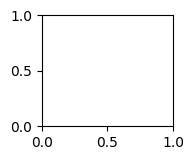

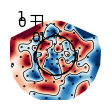

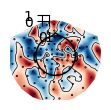

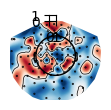

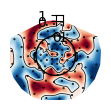

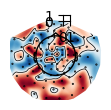

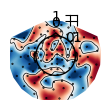

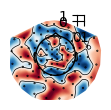

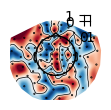

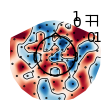

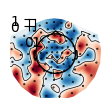

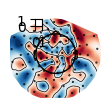

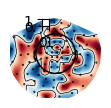

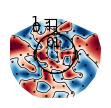

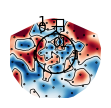

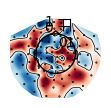

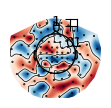

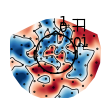

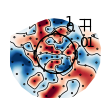

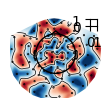

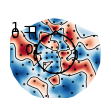

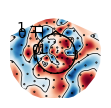

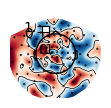

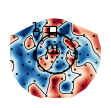

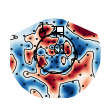

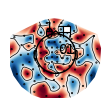

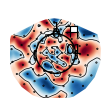

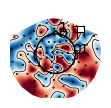

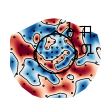

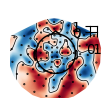

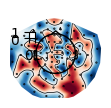

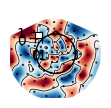

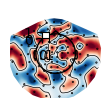

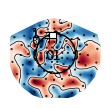

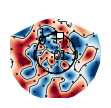

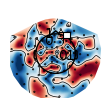

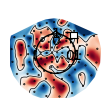

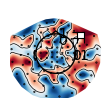

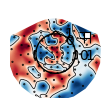

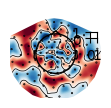

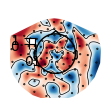

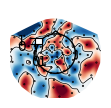

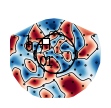

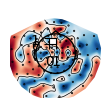

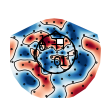

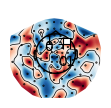

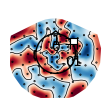

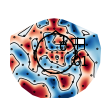

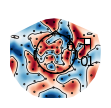

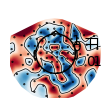

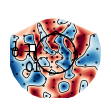

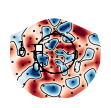

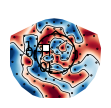

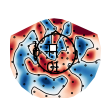

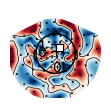

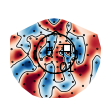

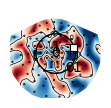

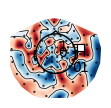

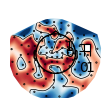

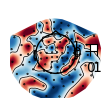

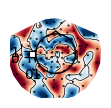

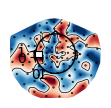

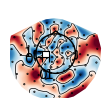

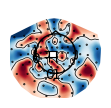

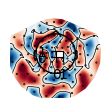

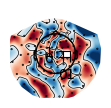

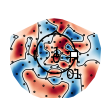

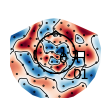

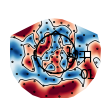

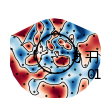

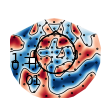

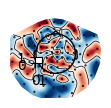

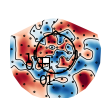

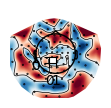

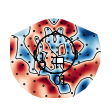

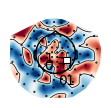

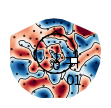

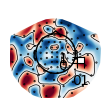

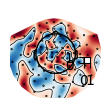

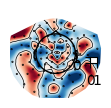

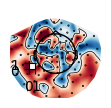

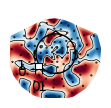

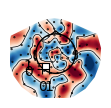

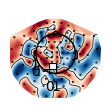

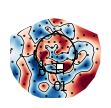

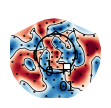

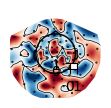

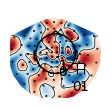

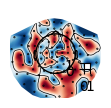

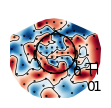

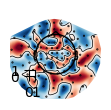

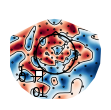

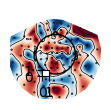

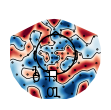

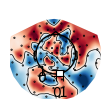

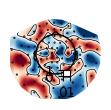

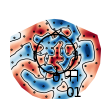

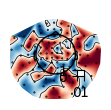

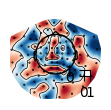

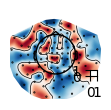

In [5]:
###############################
### EXTRACTING PARSER INFO ###
###############################

if args.eventclf:
    labels = ["visual", "auditory"]  # image is label 0 and sound label 1
elif args.subclf:
    labels = []
else:
    labels = ["male", "female"]

if args.feature == "bins":
    trial_length = 241
if args.feature == "bands":
    trial_length = 5
elif args.feature == "temporal":
    trial_length = TIME_TRIAL_LENGTH

if args.sensors == "MAG":
    n_channels = 102
    chan_index = 0
elif args.sensors == "GRAD":
    n_channels = 204
    chan_index = [1, 2]
elif args.sensors == "ALL":
    n_channels = 306
    chan_index = [0, 1, 2]

if args.fold != -1:
    fold = args.fold + 1
else:
    fold = 1
name = f"{args.model_name}_{args.seed}_fold{fold}_{args.sensors}"
suffixes = ""
if args.net_option == "custom_net":
    if args.batchnorm:
        suffixes += "_BN"
    if args.maxpool != 0:
        suffixes += f"_maxpool{args.maxpool}"

    name += f"_dropout{args.dropout}_filter{args.filters}_nchan{args.nchan}_lin{args.linear}_depth{args.hlayers}"
    name += suffixes

input_size = (n_channels // 102, 102, trial_length)

if args.subclf:
    # TODO
    raise "not yet implemented for subclf"
else:
    n_outputs = 2

if args.eventclf:
    labels = ["visual", "auditory"]
    all_saliencies = {labels[0]: [], labels[1]: []}
elif not args.subclf:
    labels = ["male", "female"]
    all_saliencies = {labels[0]: [], labels[1]: []}

viz_path = os.path.join(args.save_path, "visualizations")
if not os.path.exists(viz_path):
    os.makedirs(viz_path)

netviz_path = os.path.join(viz_path, name)
if not os.path.exists(netviz_path):
    os.makedirs(netviz_path)

######################
### LOGGING CONFIG ###
######################

if args.log:
    log_name = args.model_name
    if args.fold is not None:
        log_name += f"_fold{args.fold}"
    log_name += "_saliency_computations.log"
    logging.basicConfig(
        filename=os.path.join(args.save_path, log_name),
        filemode="a",
        level=logging.INFO,
        format="%(asctime)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p",
    )
else:
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p",
    )

#######################
### LOADING NETWORK ###
#######################

info = load_info(args.raw_path, args.datatype)
print(info)

model_filepath = os.path.join(args.save_path, name + ".pt")
net = create_net(args.net_option, name, input_size, n_outputs, DEVICE, args)
_, net_state, _ = load_checkpoint(model_filepath)
net.load_state_dict(net_state)

logging.info(net)
model_weights = []
conv_layers = []
layer_list = list(net.feature_extraction)

counter = 0
for layer in layer_list:
    if type(layer) == nn.Conv2d:
        counter += 1
        model_weights.append(layer.weight)
        conv_layers.append(layer)

#############################################
### Genrating feature importance topomaps ###
#############################################

plt.figure(figsize=(20, 17))
for i, filtr in enumerate(model_weights[0]):
    plt.subplot(10, 10, i + 1)
    im, _ = plot_topomap(
        filtr[0, :, :].detach().cpu().ravel(),
        info,
        res=128,
        show=False,
        contours=1,
        extrapolate="local",
    )
    plt.axis("off")
plt.savefig(os.path.join(viz_path, name, "filters.png"))
plt.close()

#######################################################
### Generating visualization after each conv layer ####
#######################################################

dataframe = (
    pd.read_csv(
        os.path.join(args.save_path, f"participants_info_{args.datatype}.csv"),
        index_col=0,
    )
    .sample(frac=1, random_state=args.seed)
    .reset_index(drop=True)[: args.max_subj]
)
subj_list = dataframe["sub"]

# Taking first subject form list
# (since we did dataframe.sample it is random)
sub = subj_list[0]
logging.info(f"loading random subject {sub}")

X, targets = load_data(
    dataframe.loc[dataframe["sub"] == sub],
    args.save_path,
    epoched=args.epoched,
    seed=args.seed,
    sfreq=args.sfreq,
    chan_index=chan_index,
    datatype=args.datatype,
    eventclf=args.eventclf,
    n_samples=None if args.n_samples == -1 else args.n_samples,
)
if X is None:
    logging.info(f"data from {sub} is empty.")
X = X.to(torch.float).to(DEVICE)  # can be multiple images

# Taking X[0] means we take a random trial, since X has been shuffled in load_data
random_sample = X[0][np.newaxis, :]

# Generating outputs after forward pass of each conv layer
# TODO check if we should add maxpooling to this, since it
# is usually done during forward pass
# WE PROBABLY SHOULD TODO
results = [conv_layers[0](random_sample)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [6]:
#############################
### FILTER VISUALISATIONS ###
#############################

print("filters !")
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer]
    layer_viz = layer_viz.data.cpu()
    for i, filt in enumerate(layer_viz):
        if i == 100:  # we will visualize only 10x10 blocks from each layer
            break
        plt.subplot(10, 10, i + 1)
        plt.plot(np.arange(len(filt[0])), filt[0])
    logging.info(f"Saving layer {num_layer} feature maps...")
    plt.savefig(os.path.join(viz_path, name, f"layer_{num_layer}.png"))
    plt.close()

filters !


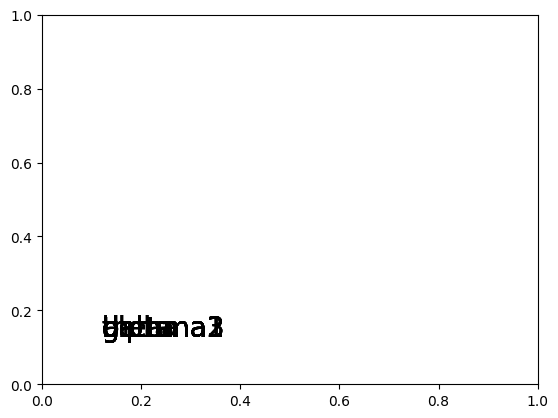

In [7]:
##########################
### LOADING SALIENCIES ###
##########################

# Always compute for both pos and neg saliencies, disregarding the args.saliency_type value
saliency_types = ("pos", "neg")

# all_options_bv are embedded lists with dimenstions: 
# saliencies x labels x subjects x sensors x frequency bands
all_options_bv = []

for saliency_type in saliency_types:
    save_path = os.path.join(
        args.save_path,
        "saliency_based_psd",
        name,
        saliency_type + f"_{args.confidence}confidence",
    )
    files = os.listdir(save_path)
    bands_values = [[] for _ in labels]
    for file in files:
        bands_values
        file_lab = file.split(".")[0].split("_")[-1]
        lab_idx = labels.index(file_lab)
        bv = np.load(os.path.join(save_path, file))
        bands_values[lab_idx].append(np.array(bv))
    for i, lab in enumerate(labels):
        bands_values[i] = np.array(np.mean(bands_values[i], axis=0))
        tname = f"All_Subjects_{saliency_type}_{lab}"
        generate_topograd_map(bands_values[i], tname, info, viz_path=viz_path, spectral=True)
    all_options_bv.append(bands_values)
all_options_bv = np.array(all_options_bv)

psd-based saliencies


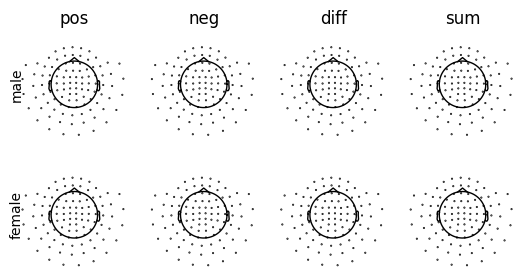

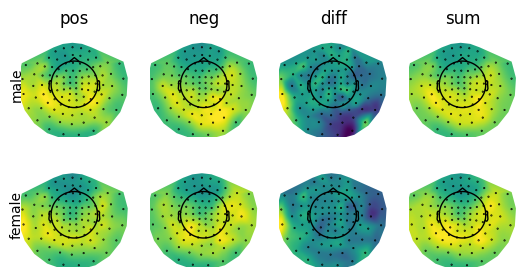

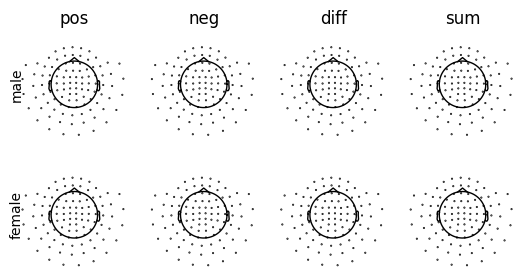

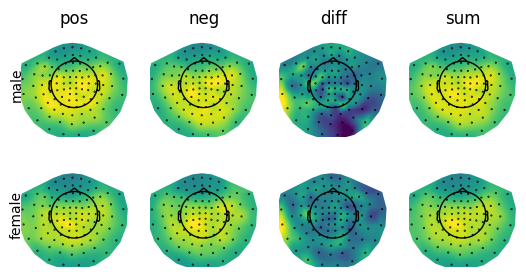

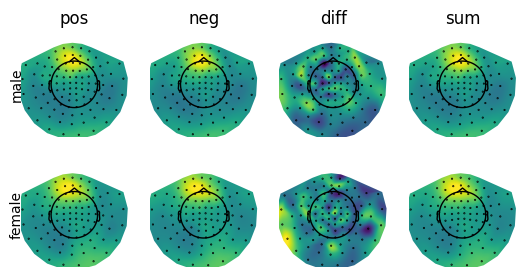

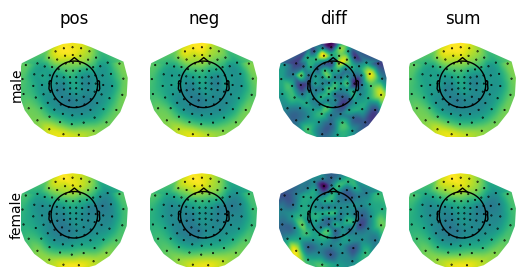

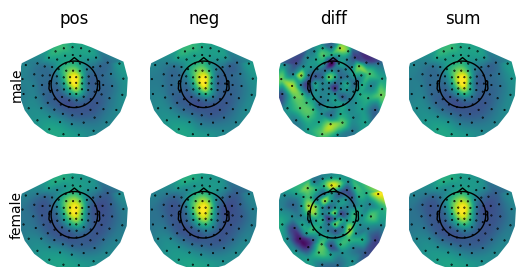

In [8]:
######################################
### GENERATING SALIENCY-BASED PSDs ###
######################################

print("psd-based saliencies")
for k, band in enumerate(BANDS):
    for i, chan in enumerate(CHANNELS):
        grid = GridSpec(len(labels)+1, 4)
        fig = plt.figure()
        # fig.clf()
        axes = []
        for j, sal in enumerate(("pos", "neg", "diff", "sum")):
            if sal in ("pos", "neg"):
                data = all_options_bv[j]
            elif sal == "diff":
                data = all_options_bv[0] - all_options_bv[1]
            else:
                data = all_options_bv[0] + all_options_bv[1]

            for l, label in enumerate(labels):
                axes.append(fig.add_subplot(grid[l, j]))
                if len(CHANNELS) > 1:
                    topo_data = data[l][i][:, k]
                else:
                    topo_data = data[l][:, k]  
                im, _ = plot_topomap(
                    topo_data,
                    info,
                    show=False,
                    contours=0,
                    res=300,
                    cmap="viridis",
                    axes=axes[-1],
                )

                if l == 0:
                    plt.title(sal)
                if j == 0:
                    axes[-1].text(-0.25, 0, label, va="center", rotation="vertical")

        figure_path = os.path.join(viz_path, f"saliency_guided_{band}_psd.png")
        plt.savefig(figure_path, dpi=300)
        plt.show()
        plt.close()
